# Lesson 6: pets revisited

Data Augmentation:
1:09:20
great way to regularise, because there are little to no costs (no extra training e.g.)

In [6]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.vision import *

In [7]:
bs = 64

In [8]:
path = untar_data(URLs.PETS)/'images'

## Data augmentation

In [9]:
## 
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

In [10]:
doc(get_transforms)

In [11]:
src = ImageItemList.from_folder(path).random_split_by_pct(0.2, seed=2)

In [12]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

In [13]:
data = get_data(224, bs, 'zeros')

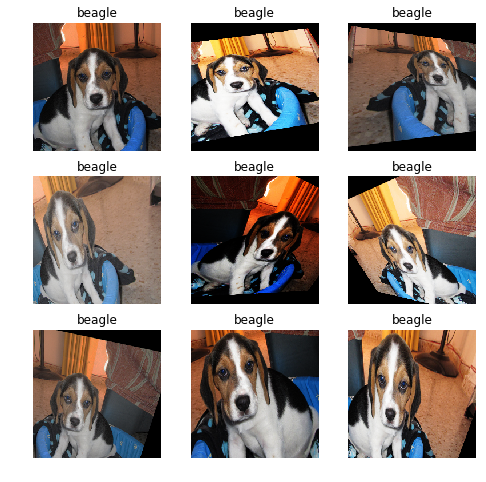

In [14]:
def _plot(i,j,ax):
    x,y = data.train_ds[3]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [15]:
data = get_data(224,bs)

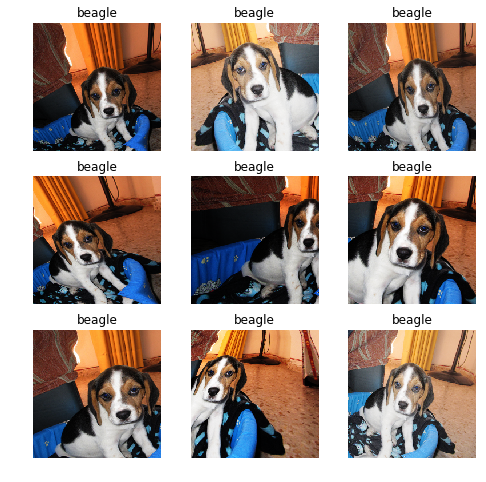

In [16]:
plot_multi(_plot, 3, 3, figsize=(8,8))

## Train a model

In [17]:
gc.collect()
learn = create_cnn(data, models.resnet34, metrics=error_rate, bn_final=True)

In [18]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate
1,2.354300,0.945392,0.175237
2,1.367224,0.308725,0.080514
3,0.882881,0.263533,0.073748


In [19]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate
1,0.685326,0.279304,0.066306
2,0.628234,0.275566,0.063599


In [20]:
data = get_data(352,bs)
learn.data = data

In [21]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.621461,0.232933,0.050068
2,0.584815,0.239364,0.048714


In [22]:
learn.save('352')

## Convolution kernel

In [23]:
data = get_data(352,16)

In [24]:
learn = create_cnn(data, models.resnet34, metrics=error_rate, bn_final=True).load('352')

Category Persian

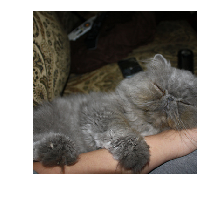

In [25]:
idx=0
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

Minute 1:50:10

In [26]:
## right edge, bottom edge (positive numbers)
## BUT we need more dimensions
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6
## copy this 3 times (well, it pretends as it refer to same block of memory)
## essentially we treat red, green and ... similar

In [27]:
from fastai.callbacks.hooks import *

In [28]:
k ## 4d tensor

tensor([[[[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]]]])

In [29]:
k.shape

torch.Size([1, 3, 3, 3])

In [30]:
t = data.valid_ds[0][0].data; t.shape

torch.Size([3, 352, 352])

In [31]:
t[None].shape ## this creates a new unit axis, so rank 4 tensor

torch.Size([1, 3, 352, 352])

In [32]:
edge = F.conv2d(t[None], k) ## mini batch with size 1

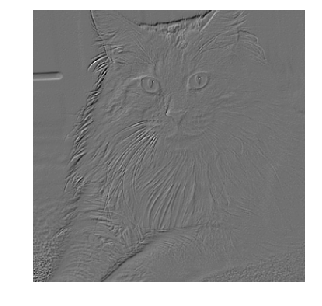

In [ ]:
show_image(edge[0], figsize=(5,5));

In [ ]:
learn.summary()

Input Size override by Learner.data.train_dl
Input Size passed in: 16 

Layer (type)               Output Shape         Param #   
Conv2d                    [16, 64, 176, 176]   9408                
________________________________________________________________________________
BatchNorm2d               [16, 64, 176, 176]   128                 
________________________________________________________________________________
ReLU                      [16, 64, 176, 176]   0                   
________________________________________________________________________________
MaxPool2d                 [16, 64, 88, 88]     0                   
________________________________________________________________________________
Conv2d                    [16, 64, 88, 88]     36864               
________________________________________________________________________________
BatchNorm2d               [16, 64, 88, 88]     128                 
________________________________________________________

## Heatmap

1:29:15
 
 http://setosa.io/ev/image-kernels/
 
 https://medium.com/impactai/cnns-from-different-viewpoints-fab7f52d159c
 
 1:54:55


In [ ]:
m = learn.model.eval();
## m[0] end of convolutional part of model

In [ ]:
xb,_ = data.one_item(x) ## create mini batch with one thing in it
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda() ## place onto the GPU

In [ ]:
from fastai.callbacks.hooks import *

In [ ]:
## note with hooks, it hooks every time
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb) ## here we do not care aboyt the predictions. we want the hook
            preds[0,int(cat)].backward() ## remove the hook
    return hook_a,hook_g

In [ ]:
hook_a,hook_g = hooked_backward() ## pytorch thing to run any pytorch code you want
## outout convoultional part of the model: pls store that for me !
## took m[0], i.e. the conv part and store it

In [ ]:
acts  = hook_a.stored[0].cpu() ## stored is fast.ai and give you the activation
acts.shape

torch.Size([512, 11, 11])

In [ ]:
avg_acts = acts.mean(0) ## so the mea eliminates the 512
avg_acts.shape ## eventually 11 features wanted

torch.Size([11, 11])

In [ ]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

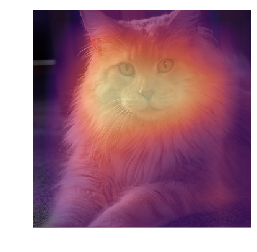

In [ ]:
show_heatmap(avg_acts)

## Grad-CAM

Paper: [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)

In [ ]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

(torch.Size([512, 11, 11]), torch.Size([512]))

In [ ]:
mult = (acts*grad_chan[...,None,None]).mean(0)

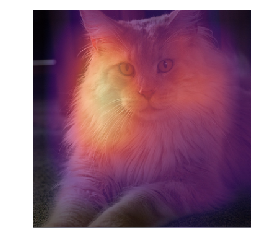

In [ ]:
show_heatmap(mult)

In [ ]:
fn = path/'../other/bulldog_maine.jpg'

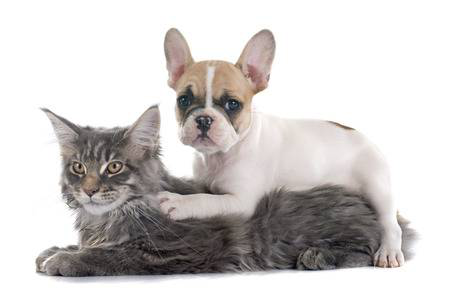

In [ ]:
x = open_image(fn); x

In [ ]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [ ]:
hook_a,hook_g = hooked_backward()

In [ ]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

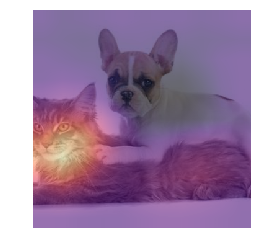

In [ ]:
show_heatmap(mult)

In [ ]:
data.classes[0]

'american_bulldog'

In [ ]:
hook_a,hook_g = hooked_backward(0)

In [ ]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

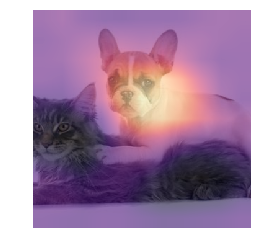

In [ ]:
show_heatmap(mult)

## fin

In [34]:
## Minute 2:10 Ethics & Data Science (generative models)


